In [7]:

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import scipy

torch.manual_seed(42)


## Simple A/B test

In [8]:
n_sim = 500 # how many permutations will we run ? (B in the lecture notes)

my_viewsA = 98 # number of clicks for video A
my_viewsB = 162 # number of clicks for video B
all_views = my_viewsA + my_viewsB

n_impsA = 1000 # number of impressions for video A (total number of people who saw video title)
n_impsB = 2000 # number of impresssion for video B
all_imps = n_impsA + n_impsB

obs_T = abs(my_viewsA/n_impsA - my_viewsB/n_impsB) # |theta_1 - theta_2|

In [9]:
my_viewsA/n_impsA

0.098

In [10]:
my_viewsB/n_impsB

0.081

In [11]:
obs_T = abs(my_viewsA/n_impsA - my_viewsB/n_impsB) # |theta_1 - theta_2|

In [12]:
obs_T

0.017

In [ ]:
# dataset 1
# (1,1,1,1...,1,0,0,...,0) (98 ones, 1000-98 zeroes) 

# dataset 2
# (1,1,1,1...,1,0,0,...,0) (162 ones, 2000-162 zeroes) 

In [ ]:
pool = np.array([1]*all_views + [0]*(all_imps - all_views))

In [26]:
# Sample without replacement for impsA
impsA = np.random.choice(pool, n_impsA, replace=False)
# new permuted dataset of size n_impsA
viewsA = np.sum(impsA)
viewsB = all_views - viewsA

P-Value: 0.1280


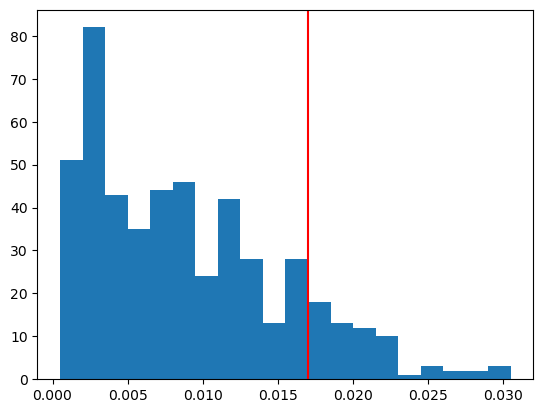

In [28]:
resampled_Ts = np.zeros(n_sim) # where to store our permutation test statistics

for cur_sim in range(n_sim):
    # Pool with 1s for views and 0s for non-views
    pool = np.array([1]*all_views + [0]*(all_imps - all_views))
    # create an array with (98+162) ones and (1000+2000 - 98-162) zeros
    
    # (1, 1, 1, 1, ..., 1, 0, 0, 0, ..., 0) (1, 1,.., 1, 0, 0, 0, 0, ...,0)
    # (1, 1, 0, 0, 0, 1, ..., 0, 1, 0, )

    # Sample without replacement for impsA
    impsA = np.random.choice(pool, n_impsA, replace=False)
    # new permuted dataset of size n_impsA
    viewsA = np.sum(impsA)
    viewsB = all_views - viewsA
    
    resampled_Ts[cur_sim] = abs(viewsA/n_impsA - viewsB/n_impsB) # | theta_1 -theta_2| for this dataset

p_value = sum([1 for t in resampled_Ts if t >= obs_T]) / n_sim

print(f"P-Value: {p_value:.4f}")


plt.hist(resampled_Ts, bins=20)
plt.axvline(obs_T, color='red')
plt.show()



In [29]:
resampled_Ts

array([0.0035, 0.002 , 0.0205, 0.0025, 0.008 , 0.004 , 0.016 , 0.0095,
       0.0185, 0.001 , 0.002 , 0.0005, 0.0085, 0.005 , 0.004 , 0.0125,
       0.007 , 0.013 , 0.0095, 0.004 , 0.0005, 0.0145, 0.0035, 0.0085,
       0.0035, 0.0125, 0.0065, 0.0125, 0.0055, 0.0085, 0.004 , 0.0115,
       0.0095, 0.0035, 0.0115, 0.0025, 0.0035, 0.0005, 0.0155, 0.0005,
       0.0065, 0.0125, 0.008 , 0.0005, 0.0035, 0.013 , 0.01  , 0.013 ,
       0.001 , 0.0005, 0.013 , 0.014 , 0.004 , 0.0175, 0.0205, 0.0125,
       0.0125, 0.0005, 0.0025, 0.001 , 0.013 , 0.0005, 0.01  , 0.017 ,
       0.005 , 0.0155, 0.0035, 0.0295, 0.0185, 0.0025, 0.0025, 0.001 ,
       0.002 , 0.0065, 0.001 , 0.0085, 0.0065, 0.0065, 0.0025, 0.0025,
       0.004 , 0.004 , 0.0145, 0.011 , 0.008 , 0.008 , 0.016 , 0.014 ,
       0.01  , 0.007 , 0.0125, 0.005 , 0.0155, 0.022 , 0.008 , 0.0085,
       0.0125, 0.008 , 0.002 , 0.01  , 0.007 , 0.0145, 0.0125, 0.002 ,
       0.0145, 0.007 , 0.005 , 0.0065, 0.013 , 0.011 , 0.0035, 0.0035,
      

## Independence test with neural networks

In [30]:
class NNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(NNet, self).__init__()
        self.sequential = nn.Sequential(
            nn.Linear(in_dim, 2*in_dim),
            nn.ReLU(),
            nn.Linear(2*in_dim, out_dim))

    def forward(self, x):
        return self.sequential(x)

In [45]:
# let's create a simulated dataset where Y depends on X through B
# Y = XB + noise
# ideally we should reject the null hypothesis that Y and X are independent (because they're not)

p1 = 5 # dimension of X
p2 = 3 # dimension of Y

signal_strength = 0.2

n_samples = 10000

X = np.random.randn(n_samples, p1)

B = np.random.randn(p2, p1)
B = B / np.linalg.norm(B, ord='fro') # some parameter

Y = signal_strength * X @ B.T + np.random.randn(n_samples, p2)
# Y = B X + random noise

X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

In [41]:
def trainerr(x, y, epochs=100):

    # trains a neural network to predict y from x

    net = NNet(p1, p2)

    optimizer = optim.Adam(net.parameters(), lr=0.2)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(x)
        
        loss = nn.MSELoss(reduction='mean')(outputs, y)
        loss.backward()
        optimizer.step()
        
    return loss.item()

# our observed test statistic is the loss in predicting y from x
obs_T = trainerr(X, Y)

In [42]:
obs_T

0.9884689450263977

In [43]:
# Perform permutation testing
n_permutations = 300
resampled_Ts = []

for _ in range(n_permutations):
    permuted_Y = Y[torch.randperm(n_samples)]
    resampled_T = trainerr(X, permuted_Y) # train a neural network, output training loss
    resampled_Ts.append(resampled_T)


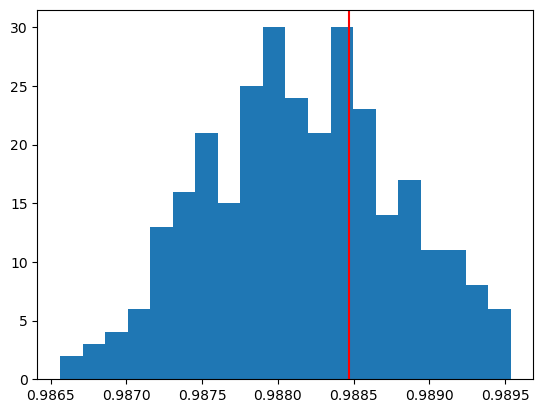

Observed test statistic: 0.9885
P-Value: 0.6767


In [44]:
# Calculate p-value
p_value = sum([1 for t in resampled_Ts if t <= obs_T]) / n_permutations

# plot distribution of permuted_test_statistics
plt.hist(resampled_Ts, bins=20)
plt.axvline(obs_T, color='red')
plt.show()


print(f"Observed test statistic: {obs_T:.4f}")
print(f"P-Value: {p_value:.4f}")



In [46]:
## sample split
ntrain = int(n_samples * 0.7) # train on 70% of the data
ntest = n_samples - ntrain

X_train = X[:ntrain]
X_test = X[ntrain:]

Y_train = Y[:ntrain]
Y_test = Y[ntrain:]

net = NNet(p1, p2)

Y_train_centered = Y_train - torch.mean(Y_train, dim=0)


In [47]:
epochs = 200
optimizer = optim.SGD(net.parameters(), lr=.1)
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = net(X_train)
        
    loss = nn.MSELoss(reduction='mean')(outputs, Y_train_centered)
    loss.backward()
    optimizer.step()

testerrs = torch.sum((Y_test - net(X_test) - torch.mean(Y_train, dim=0))**2, dim=1)
mean_testerr = torch.mean(testerrs)

In [50]:
testerrs

tensor([2.9590, 2.7678, 1.1140,  ..., 3.0615, 1.2602, 0.5417],
       grad_fn=<SumBackward1>)

In [51]:
nullerrs = torch.sum((Y_test - torch.mean(Y_train, dim=0))**2, dim=1)
mean_nullerr = torch.mean( nullerrs )

In [52]:
nullerrs

tensor([2.9330, 2.5011, 0.8988,  ..., 2.9327, 1.8179, 0.6541])

In [53]:
print(f"Mean Test Errors: {mean_testerr:.4f}")
print(f"Mean Null Test Errors: {mean_nullerr:.4f}")

obs_T = mean_testerr - mean_nullerr

Mean Test Errors: 3.0441
Mean Null Test Errors: 3.0612


In [54]:
combined = torch.stack((testerrs, nullerrs), dim=1)


In [55]:
combined

tensor([[2.9590, 2.9330],
        [2.7678, 2.5011],
        [1.1140, 0.8988],
        ...,
        [3.0615, 2.9327],
        [1.2602, 1.8179],
        [0.5417, 0.6541]], grad_fn=<StackBackward0>)

In [56]:
heads = torch.randint(0, 2, (ntest,))

resampled_testerrs = combined[torch.arange(ntest), heads]
resampled_nullerrs = combined[torch.arange(ntest), 1-heads]
    

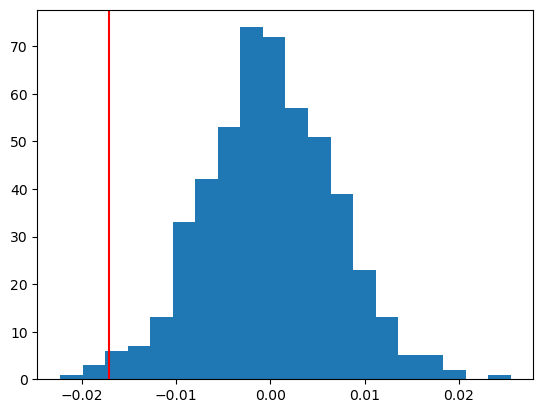

P-Value: 0.0100


In [58]:

n_permutations = 500
resampled_Ts = []

for _ in range(n_permutations):
    heads = torch.randint(0, 2, (ntest,))

    resampled_testerrs = combined[torch.arange(ntest), heads]
    resampled_nullerrs = combined[torch.arange(ntest), 1-heads]
    # test error using X - test error not using X
    resampled_T = torch.mean(resampled_testerrs) - torch.mean(resampled_nullerrs)
    resampled_Ts.append(resampled_T)

## Calculate p-value
p_value = sum([1 for t in resampled_Ts if t <= obs_T]) / n_permutations

resampled_Ts = [t.detach().numpy() for t in resampled_Ts]
plt.hist(resampled_Ts, bins=20)
plt.axvline(obs_T.detach().numpy(), color='red')
plt.show()

print(f"P-Value: {p_value:.4f}")
